# Прогнозирование вероятности оттока пользователей для фитнес-центров

# Описание проекта:

На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей

## Загрузите данные

In [1]:
#импорты выношу в отдельную ячейку:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
#загружаем данные:
df = pd.read_csv('/datasets/gym_churn.csv')
display(df.head())
display(df.info())
#display(df['Contract_period'].value_counts())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

Вывод:
файл открыт и изучен:  
всего 4000 строк, 14 столбцов.  
Пропусков нет.   
Типы соответствуют.  
Все признаки числового типа.   
Целевая переменная - Churn так же числового типа.  
Можно округлить значения до целого в столбце Month_to_end_contract,   
так как речь идет о месяцах и в таблице месяца - целые значения.  
А так же округлить до второго знака значения в столбце Avg_additional_charges_total,    
так как это сумма выручка.

In [3]:
#округляем значения до целого:
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int')
#округляем значения до второго знака:
df['Avg_additional_charges_total'] = df['Avg_additional_charges_total'].round(2)

#проверим наличие дубликатов:
#display(df.duplicated().sum())
print(f"Количество дубликатов: {df.duplicated().sum()}")

#проверяем результаты:
display(df.head())
display(df.info())

Количество дубликатов: 0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null int64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


None

Вывод:  
с данными проблем нет, готовы к анализу

## Проведите исследовательский анализ данных (EDA)

### Смотрим на датасет: выясняем есть ли в нем отсутствующие признаки, изучаем средние значения и стандартные отклонения

In [4]:
display(df.describe())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943730,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355654,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.150000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.865000,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220000,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.947500,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590000,12.000000,31.000000,6.023668,6.146783,1.000000


Вывод:  
отсутствующих признаков нет, по столбцам: gender, Partner, Contract_period, Group_visits, Month_to_end_contract,Lifetime, разница между средним значением и стандартным отклонением невелика, т.е. почти все значения близки к среднему значению.
В остальных столбцах разница значительная, значения не однородные, возможно есть выбросы.  
  
портрет среднестатистического клиента представляет собой примерно в равной степени по количеству мужчин и женщин (почти равные доли), почти все проживающие рядом с фитнесом, в среднем являются сотрудниками партнеров фитнеса, большинство имеет телефон, как правило срок действия абонементов около 6 месяцев, в среднем все посещают групповые занятия, возраст в среднем около 29 лет.

### Смотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [5]:
display(df.groupby('Churn').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445716,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082903,1.662582,0.990575,1.474995,1.044546


Вывод:  
Средние значения в столбцах: gender, Phone, и думаю что можно сюда причислить Near_Location	близки в двух группах.  
Т.е различия не значительны.  
Почему решил сюда отнести признак Near_Location - оба значения близки к единице, что говорит о том,
что в обеих группах как в ушедшей, так и в той в которой остались среднее значение близко к единице (живут в данном районе и те кто остался и те кто ушел)  
По среднему значению признака Contract_period видно, что ушли те кто планировал долго заниматься по контракту.  

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

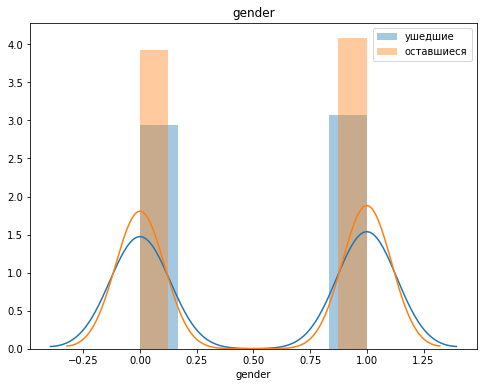

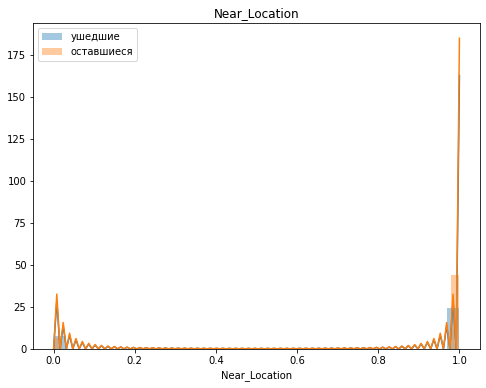

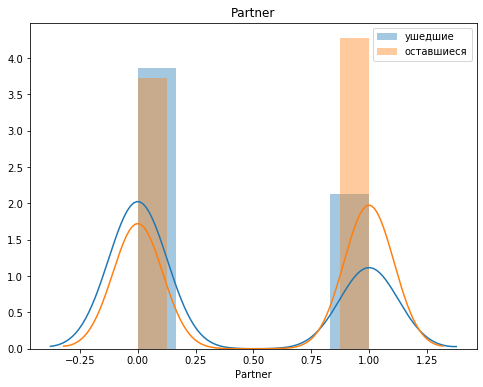

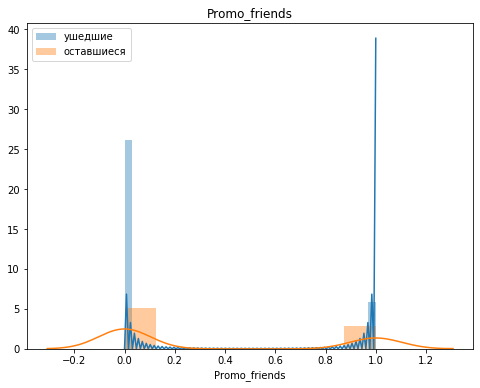

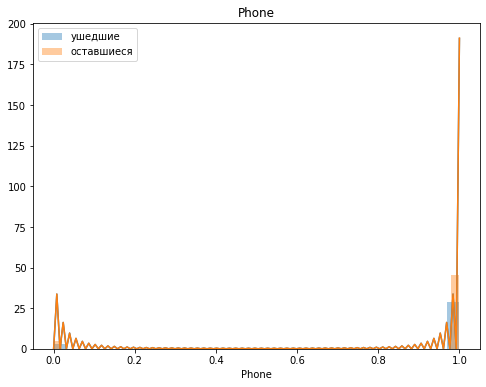

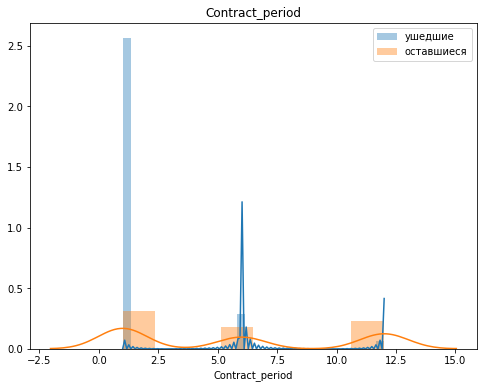

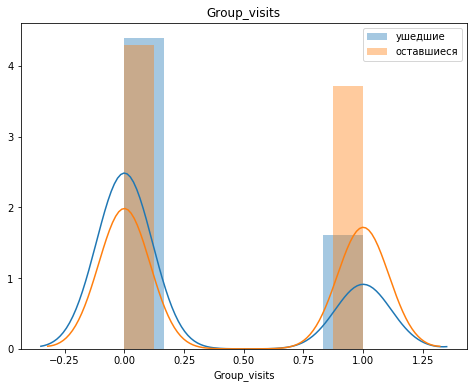

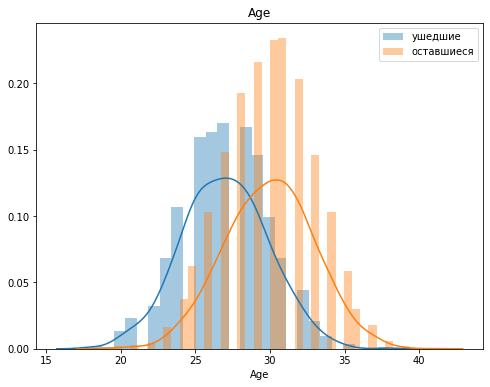

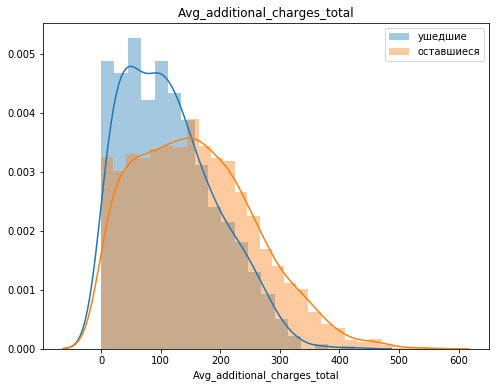

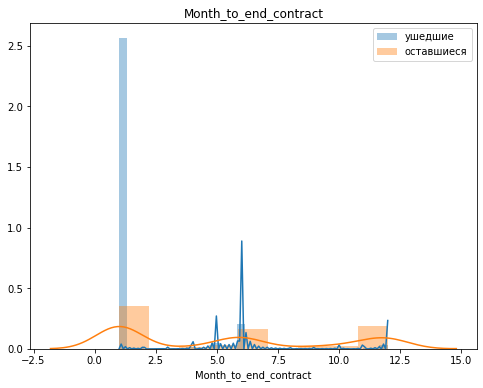

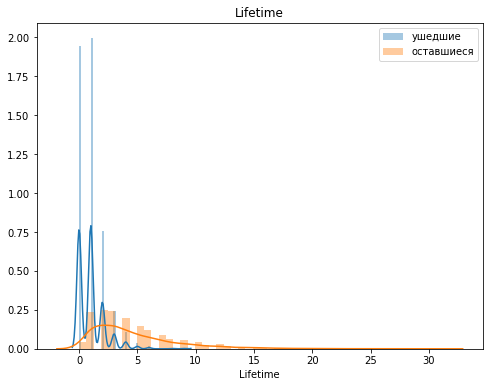

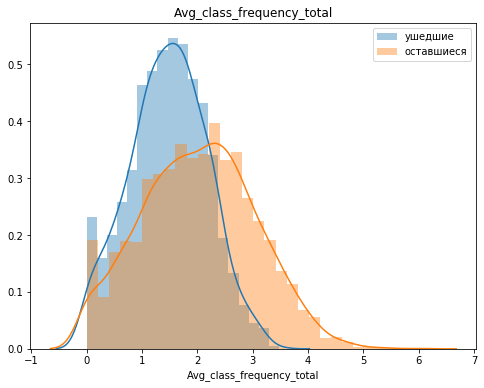

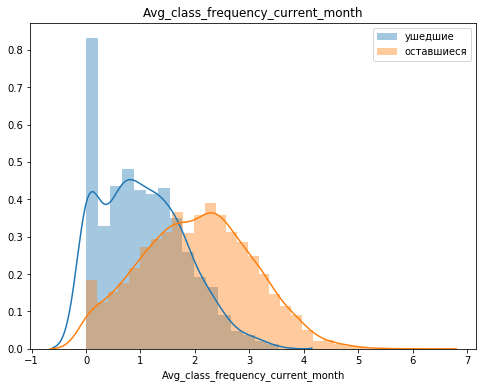

In [6]:
#делаем два среза:
df_1 = df[df['Churn'] == 1] #cрез с оттоком
df_0 = df[df['Churn'] == 0] #cрез с оставшимися

#строим стобчатые диаграммы:
for feature in df_1.drop('Churn', axis = 1).columns:
    plt.figure(figsize=(8, 6))
    sns.distplot(df_1[feature], label='ушедшие')
    sns.distplot(df_0[feature], label='оставшиеся')
    plt.title(feature)
    plt.legend()
    plt.show()

Вывод:    
Признак "пол" - мужчин осталось больше чем женщин.    
Признак "расположение" - больше оставшихся кто живет в близи.  
Признак "сотрудник компании-партнёра клуба" - оставшихся и являющихся партнерами клуба, немного больше чем тех,   
кто не является партнером, включая ушедших и оставшихся.  
Признак "акции «приведи друга»" - не взирая на акцию, ушедших больше, чем оставшихся.  
Признак "наличие телефона" - с телефонами оставшихся больше.  
Признак "длительность текущего действующего абонемента" - больше всего ушедших из тех,
кто приобрел абонемент на 1 месяц. 
Признак "посещение групповых занятий" - из тех кто посещает групповые занятия, больше оставшихся.   
Признак "возраст" - остаются те кому в районе 32 лет.    
Признак "суммарная выручка от других услуг" - соответственно выручка больше от тех кто остался.  
Признак "срок до окончания" - аналогичная ситуация тем кто ушел в первый месяц.    
Признак "Lifetime" - картина та же для тех кто ушел в первые месяцы.   
Признак "средняя частота посещений в неделю" - вначале чаще занимались ушедшие.    
Признак "средняя частота посещений в неделю за предыдущий месяц" - вначале чаще занимались ушедшие.   

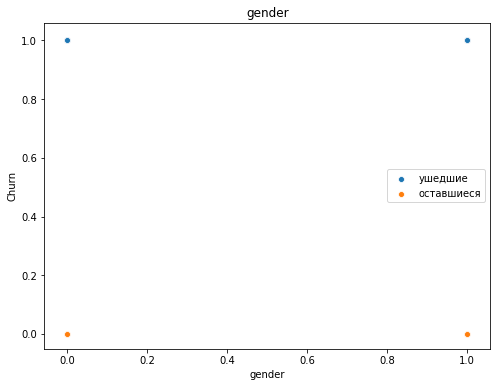

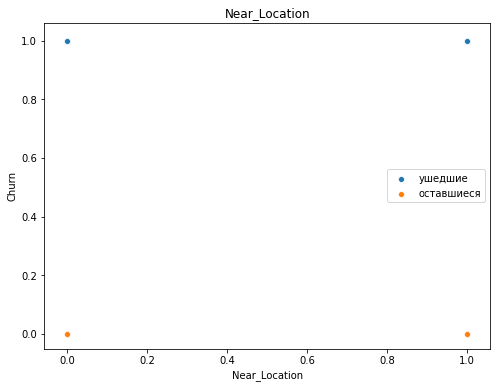

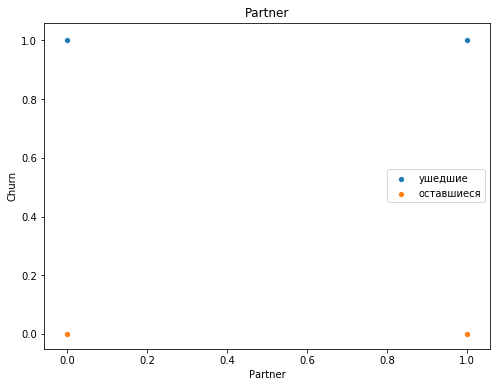

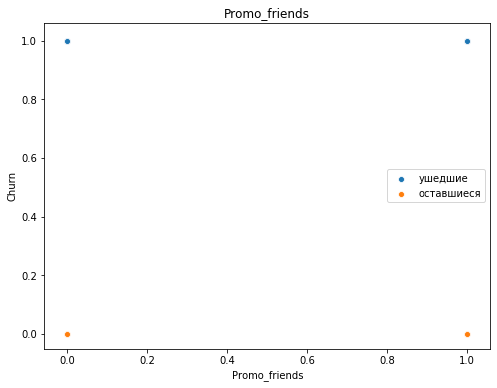

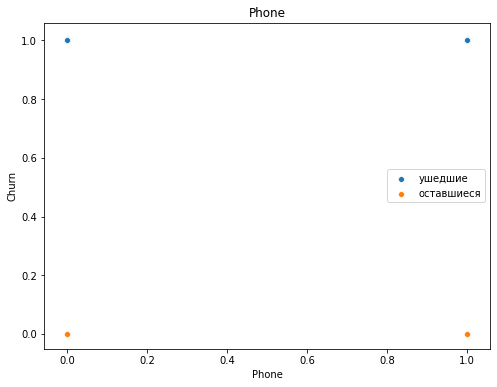

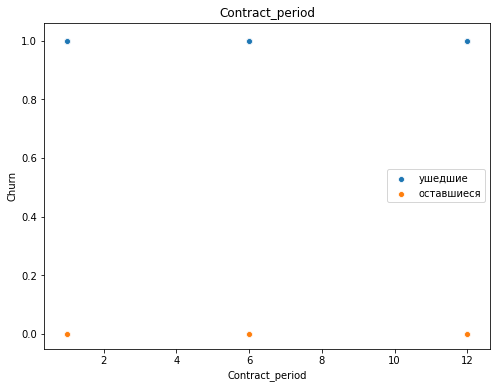

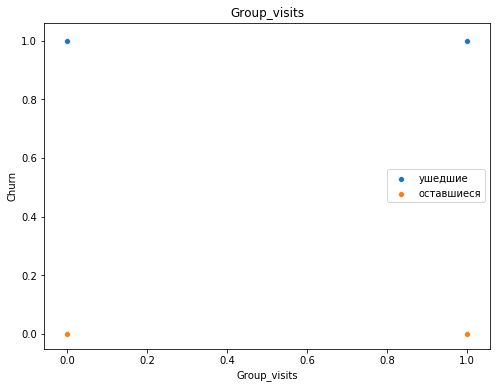

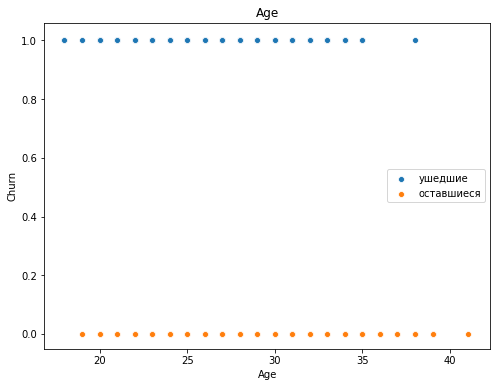

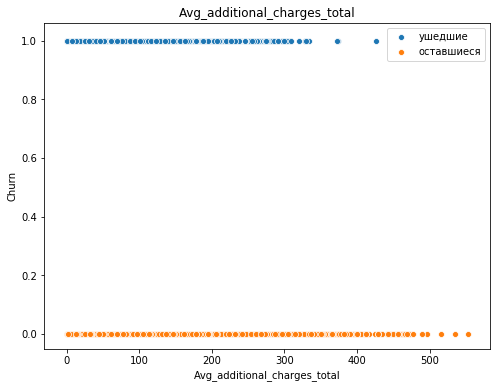

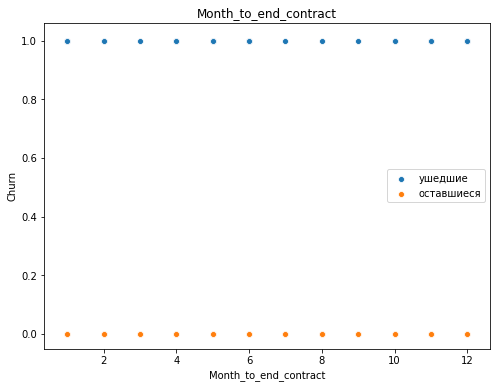

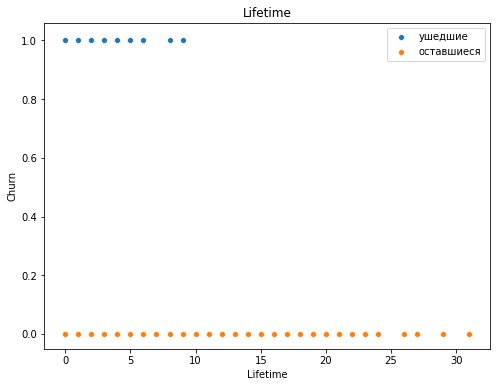

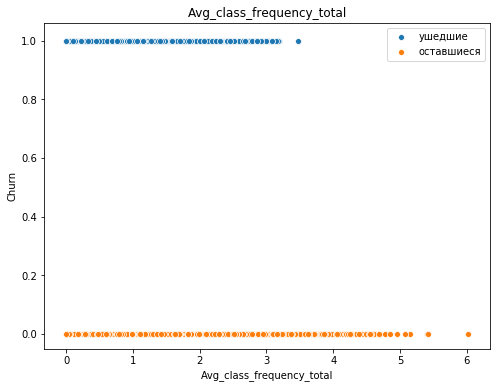

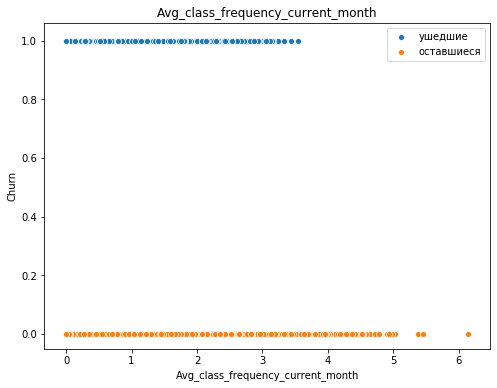

In [7]:
#строим распределения:
for col in df_1.drop('Churn', axis = 1).columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(df_1[col], df_1['Churn'], label='ушедшие')
    sns.scatterplot(df_0[col], df_0['Churn'], label='оставшиеся')
    plt.title(col)
    plt.legend()
    plt.show()

Вывод:  
серьезных выбросов не заметно.

### Построим матрицу корреляций и отобразим её

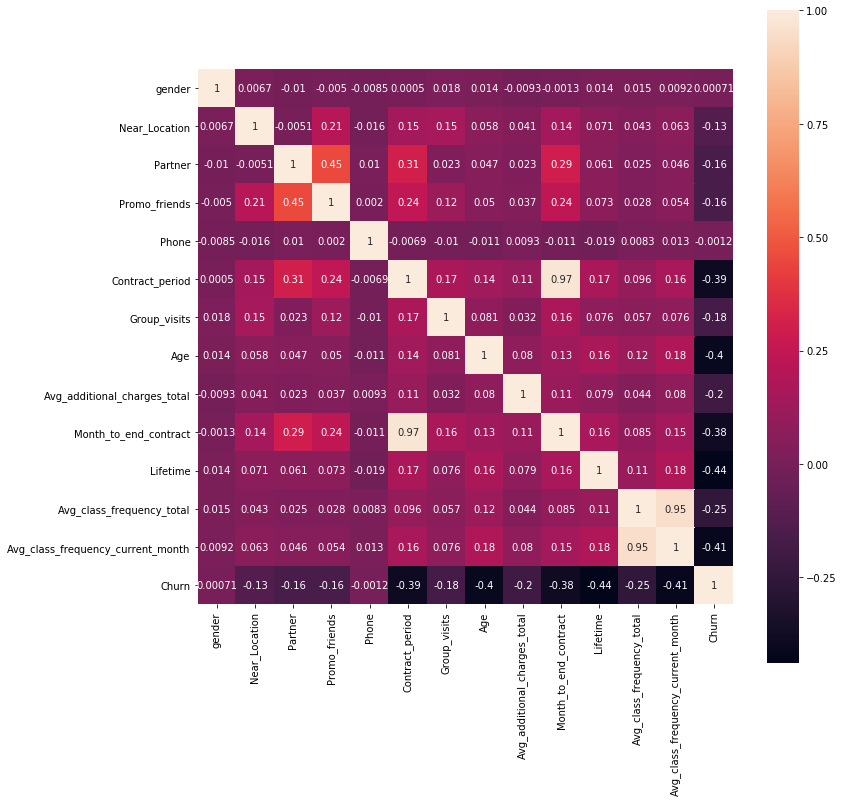

In [8]:
cm = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot = True, square=True)

Вывод: 
все признаки незначительно коррелируют с целевой переменной - это хорошо.  
В основном, признаки между собой так же мало коррелируют, но есть некотррые признаки с большой 
взаимной корреляцией, такие как:   
'Contract_period' — длительность текущего действующего абонемента с 'Month_to_end_contract' — срок до окончания текущего действующего абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц с 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента.  
Думаю убрать по одному столбцу из парных сильно коррелирующих признаков.  

теперь данные готовы к прогнозированию:
4000 наблюдений и 11 признаков, выборка достаточно большая

## Построим модель прогнозирования оттока клиентов

In [9]:
# делим данные на признаки (матрица X) и целевую переменную (y):
X = df.drop('Churn', axis = 1)
y = df['Churn']
# делим модель на обучающую и валидационную выборку:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# задаем алгоритм для нашей модели — логистическая регрессия:
model_L = LogisticRegression(solver='liblinear', random_state=0)
# задаем алгоритм для нашей модели — случайный лес:
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучаем модели:
model_L.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_L = model_L.predict(X_test)
predictions_rf = model_rf.predict(X_test)
#display(predictions_L)
# выведим метрики для полученного прогноза:
print('Accuracy_LogisticRegression: {:.2f}'.format(accuracy_score(y_test, predictions_L)))
print('Precision_LogisticRegression: {:.2f}'.format(precision_score (y_test, predictions_L)))
print('Recall_LogisticRegression: {:.2f}'.format(recall_score (y_test, predictions_L)))
print()
print('Accuracy_RandomForestClassifier: {:.2f}'.format(accuracy_score(y_test, predictions_rf)))
print('Precision_RandomForestClassifier: {:.2f}'.format(precision_score (y_test, predictions_rf)))
print('Recall_RandomForestClassifier: {:.2f}'.format(recall_score (y_test, predictions_rf)))

Accuracy_LogisticRegression: 0.93
Precision_LogisticRegression: 0.86
Recall_LogisticRegression: 0.83

Accuracy_RandomForestClassifier: 0.91
Precision_RandomForestClassifier: 0.83
Recall_RandomForestClassifier: 0.82


Вывод:
лучше модель — логистическая регрессия, которая прогнозирует по полноте 83% ответов, по точности - 86%, и с долей правильных ответов 93%.  

## Сделаем кластеризацию клиентов

### Стандартизируем данные и нарисуем дендрограмму

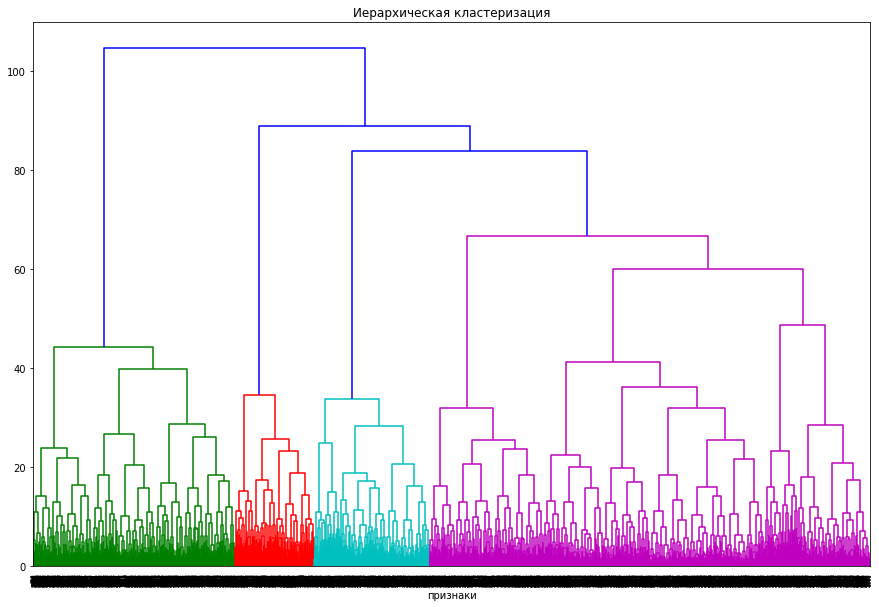

In [10]:
df_k = df.drop('Churn', axis = 1) #откладываем в сторону столбец с оттоком

# стандартизируем данные
sc = StandardScaler()
# обучаем нормализатор и преобразуем набор данных
X_sc = sc.fit_transform(df_k) 
#строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем дендрограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title("Иерархическая кластеризация")
plt.xlabel("признаки")
plt.show()

Вывод:  
предполагаю, что оптимальное число кластеров 4 — четыре разных цвета на графике.  
Однако согласно заданию (рекомендациям к инструкции по выполнению проекта в дальнейшем шаге возьму 5 кластеров)

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [11]:
km = KMeans(random_state=0, n_clusters = 5) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
df_k['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(df_k.groupby(['cluster_km']).mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.707112,9.950544,4.738872,1.983305,1.976225
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957688,4.475325,3.924675,1.847220,1.716369
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457267,2.198020,2.809901,1.660461,1.477324
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622163,1.856577,2.440571,1.247634,1.012983
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724289,2.455197,4.896057,2.851531,2.849473


Вывод:    
    
    Профиль 0:
    равное количество мужчин и женщин, почти все проживают рядом с фитнесом, 3/4 являются сотрудниками компаний партнеров 
    фитнеса, около половины из них использовали промокод от знакомого в рамках акции "приведи друга", у всех есть телефон,
    абонемент на 12 месяцев, половина посещает групповые занятия, средний возраст 30 лет, клиенты данного профиля приносят
    почти максимальную выручку, в среднем посещают фитнес два раза в неделю.  
      
    Профиль 1:
    почти равное количество мужчин и женщин, большинство проживают рядом с фитнесом, меньше половины являются сотрудниками
    компаний партнеров фитнеса, около 1/3 из них использовали промокод от знакомого в рамках акции "приведи друга", ни у кого
    нет телефона, абонемент на 6 месяцев, меньше половины посещает групповые занятия, средний возраст 29 лет, клиенты данного
    профиля приносят меньше выручки чем клиенты профиля 0, в среднем посещают фитнес меньше двух раз в неделю.  
    
    Профиль 2:
    почти равное количество мужчин и женщин, все живут далеко от фитнеса, меньше половины являются сотрудниками
    компаний партнеров фитнеса, только единицы из них использовали промокод от знакомого в рамках акции "приведи друга",
    у всех есть телефон, абонемент на 3 месяца, меньше четверти посещает групповые занятия, средний возраст 28 лет,
    клиенты данного профиля приносят меньше выручки чем клиенты профиля 1, в среднем посещают фитнес 1.5 раза в неделю.  
    
    Профиль 3:
    почти равное количество мужчин и женщин, почти все проживают рядом с фитнесом, треть являются сотрудниками
    компаний партнеров фитнеса, четверть из них использовали промокод от знакомого в рамках акции "приведи друга",
    у всех есть телефон, абонемент на 3 месяца, треть посещает групповые занятия, средний возраст 28 лет,
    клиенты данного профиля приносят меньше выручки чем клиенты профиля 2, в среднем посещают фитнес 1 раз в неделю.  
    
    Профиль 4:
    почти равное количество мужчин и женщин, почти все проживают рядом с фитнесом, треть являются сотрудниками
    компаний партнеров фитнеса, меньше четверти из них использовали промокод от знакомого в рамках акции "приведи друга",
    почти у всех есть телефон, абонемент на 3 месяца, меньше половины посещает групповые занятия, средний возраст 30 лет,
    клиенты данного профиля приносят больше всего выручки чем клиенты остальных профилей, в среднем посещают фитнес 3 раза
    в неделю.   

### Построим распределения признаков для кластеров

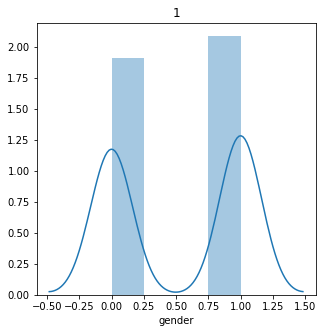

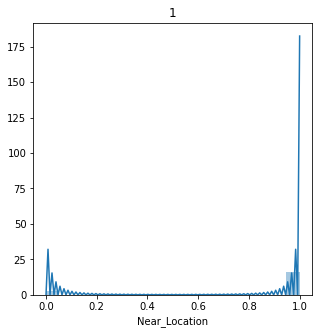

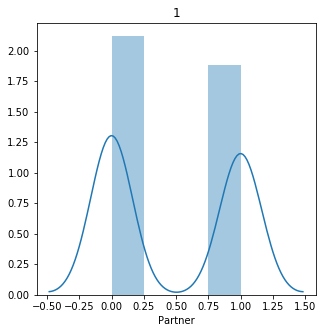

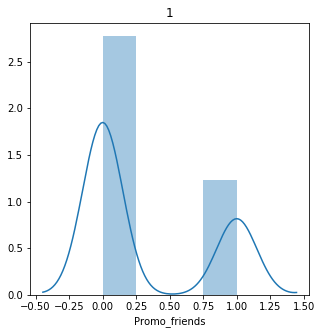

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


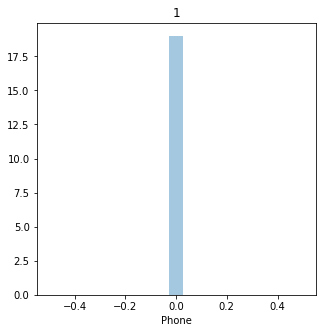

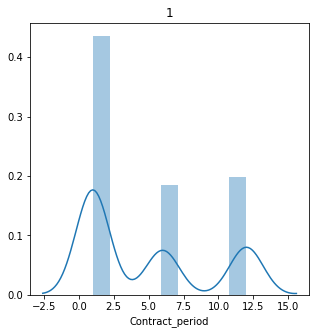

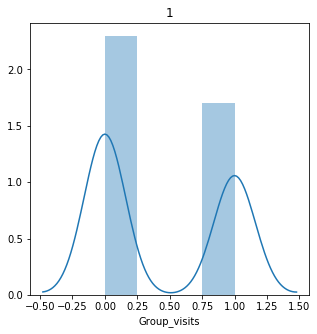

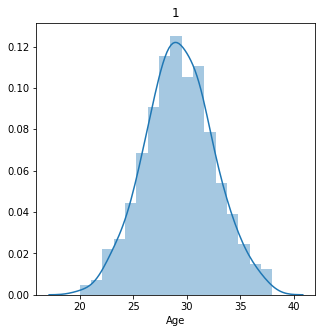

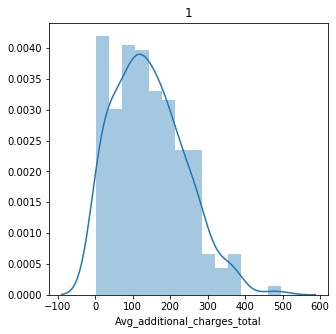

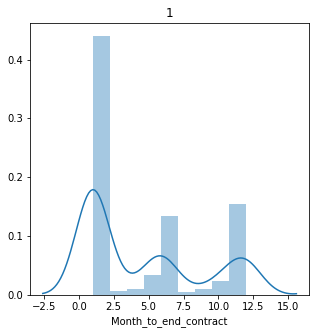

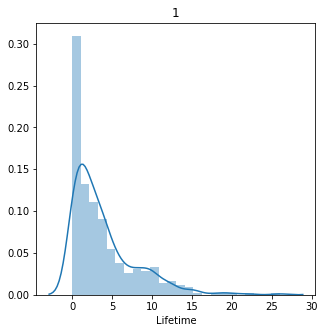

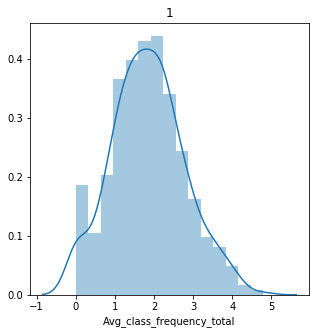

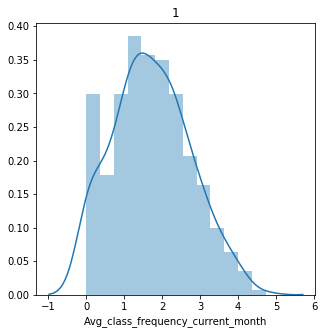

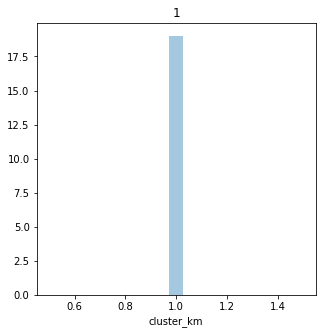

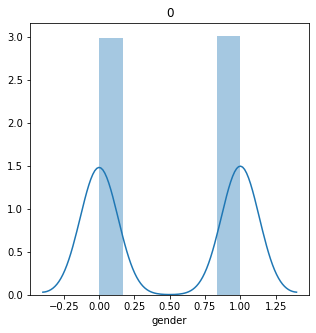

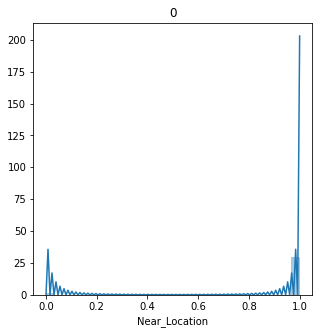

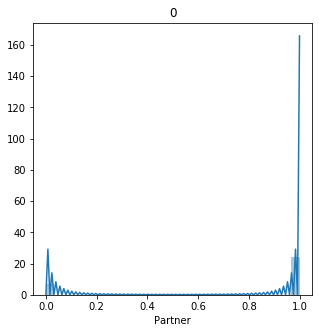

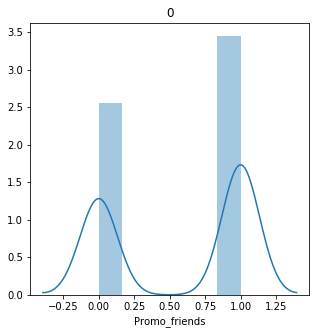

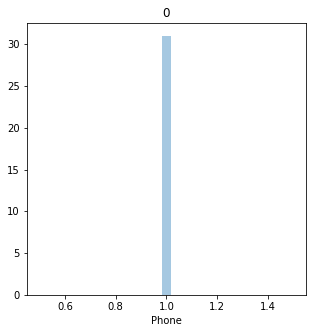

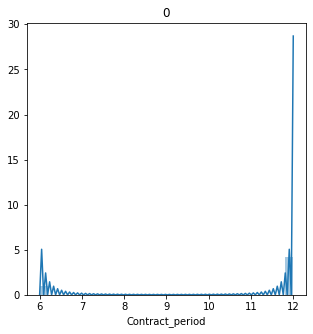

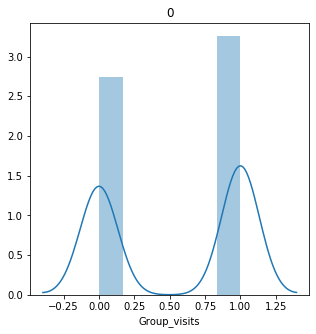

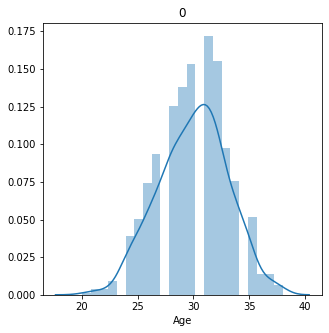

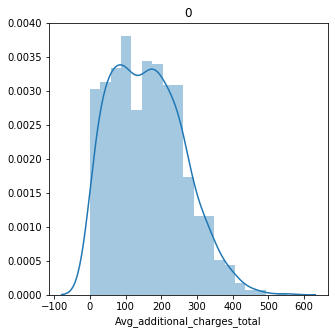

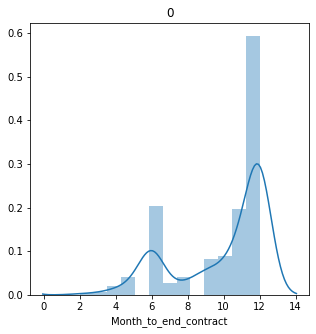

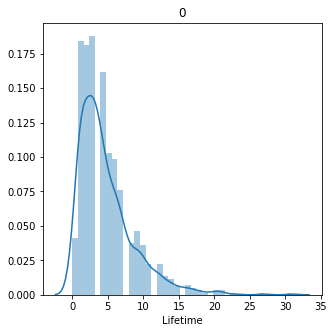

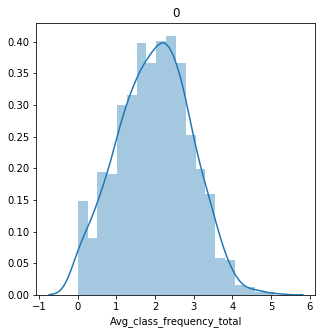

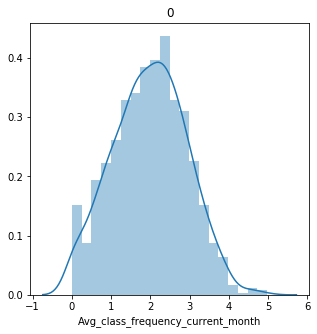

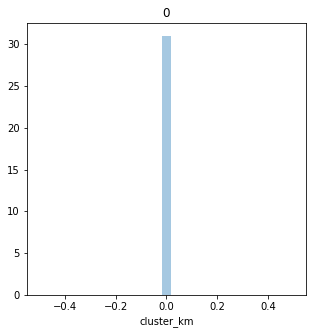

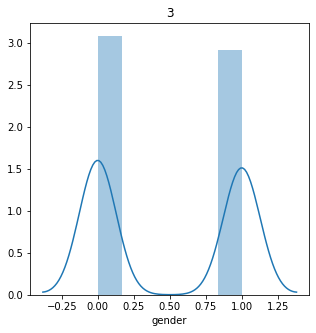

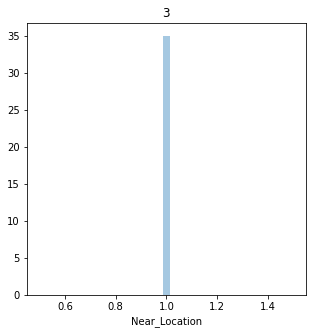

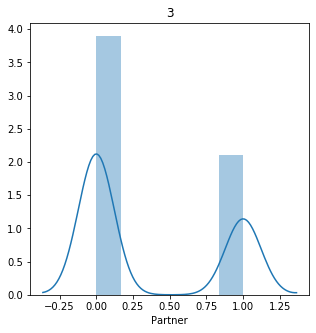

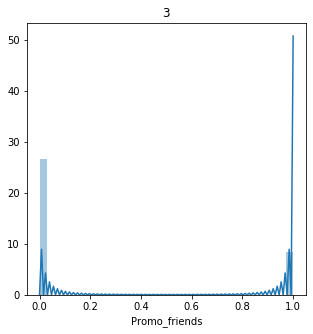

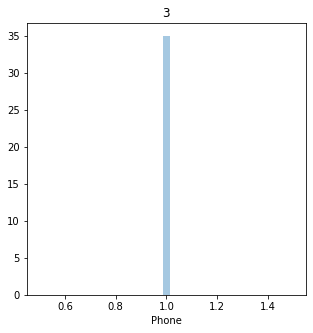

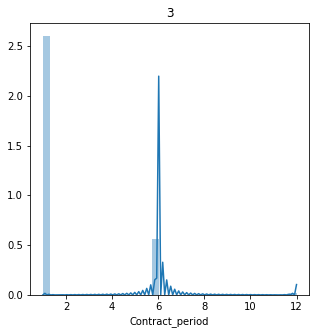

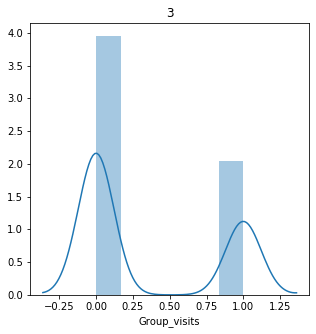

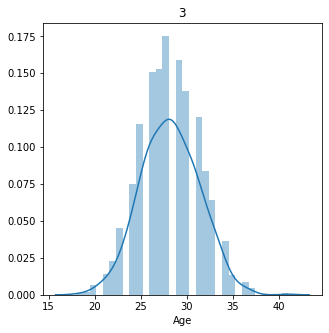

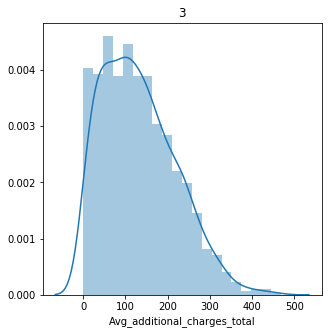

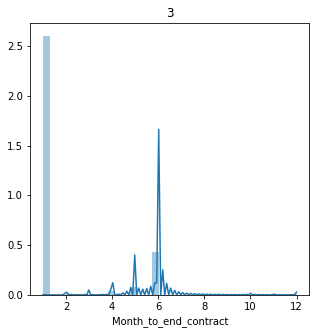

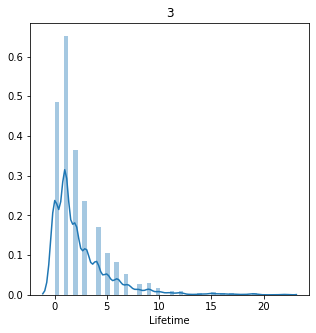

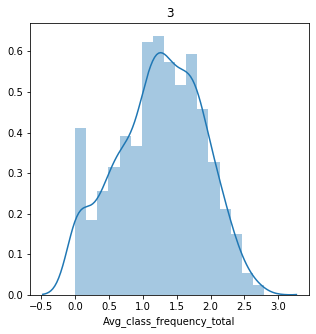

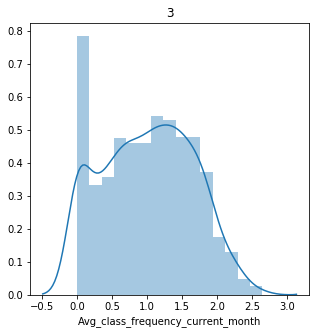

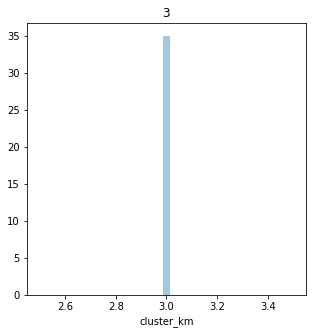

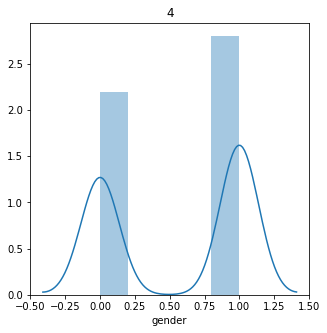

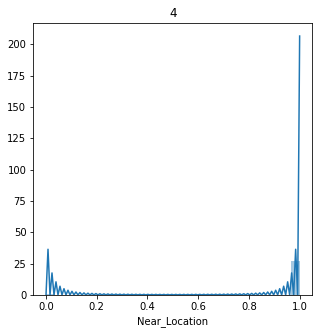

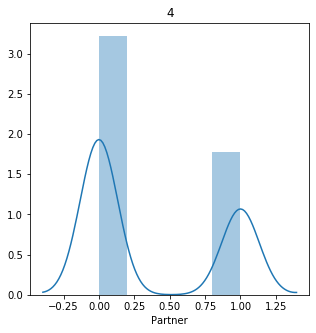

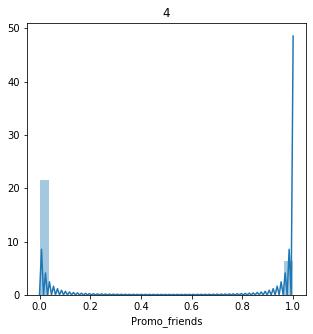

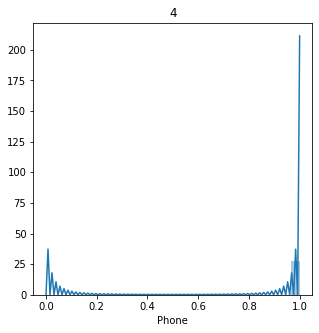

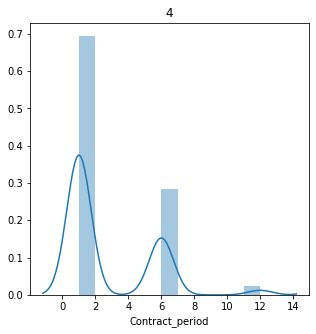

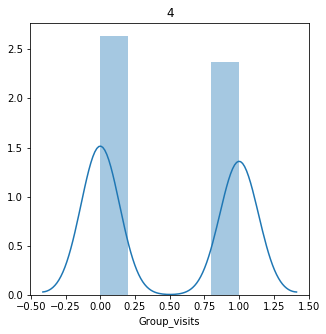

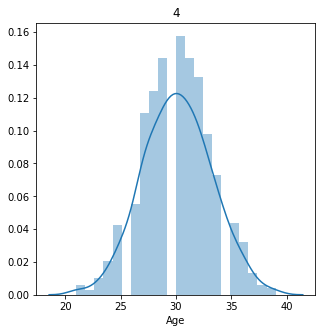

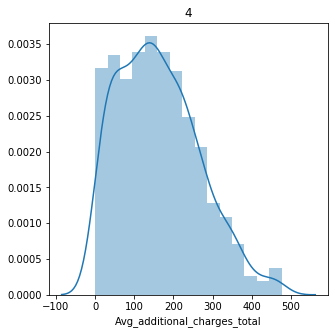

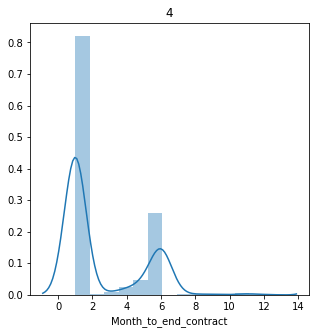

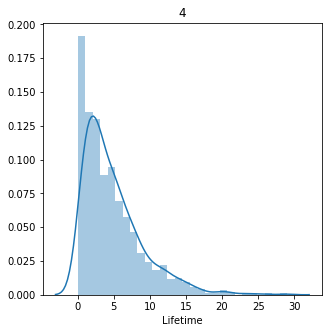

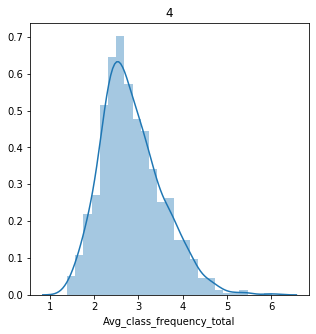

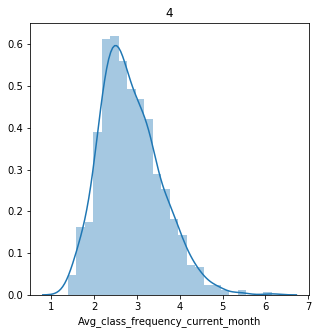

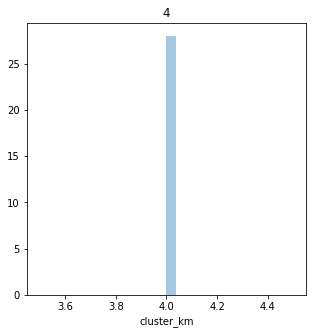

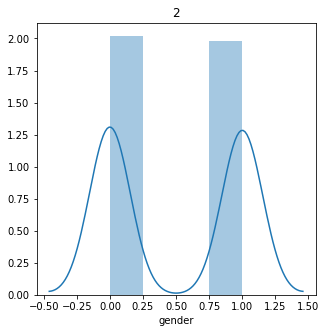

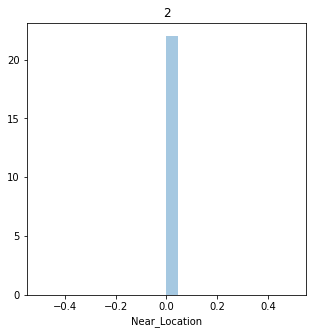

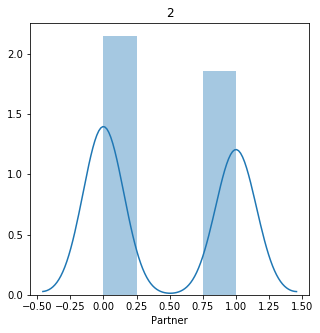

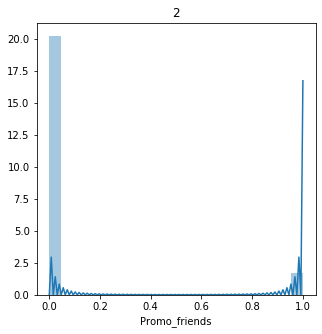

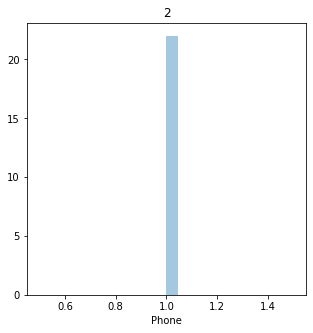

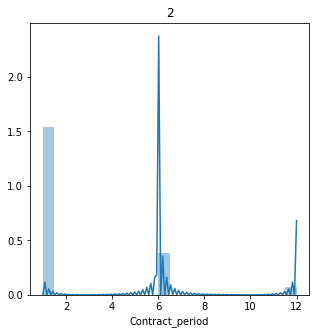

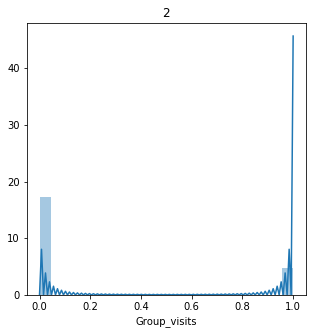

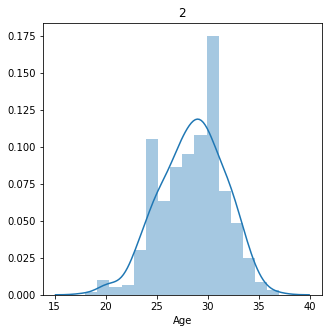

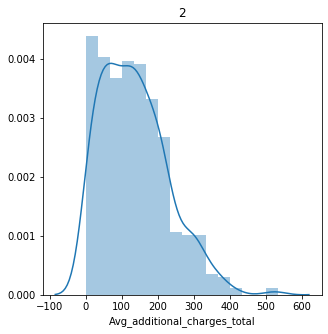

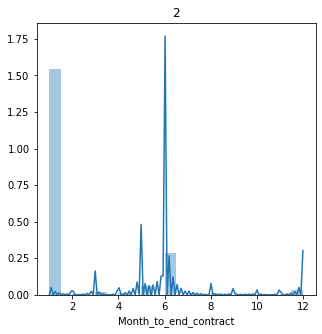

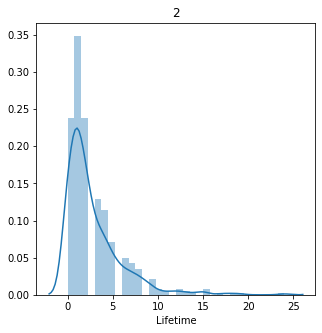

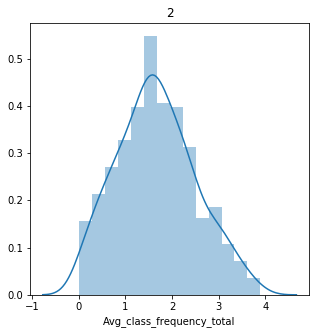

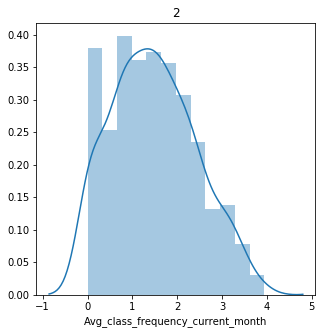

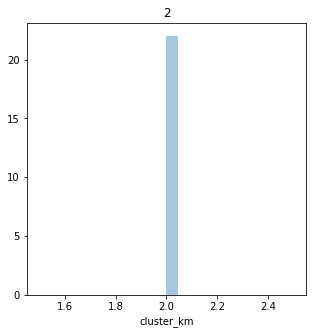

In [12]:
for i in df_k['cluster_km'].unique():
    for j in df_k.columns:
        plt.figure(figsize=(5, 5))
        sns.distplot(df_k[df_k['cluster_km']==i][j])
        plt.title(i)
        plt.show()        

<div class="alert alert-block alert-info">
    <b> Комментарий от cтудента: 1 </b>  
       
    спасибо, попробую разобраться в свободную минутку 
    
</div>

Вывод:  
распределения дублируют средние значения признаков для кластеров.

### Считаем долю оттока

In [13]:
# сохраняем метки кластера в поле исходного датасета
df['cluster_km'] = labels
#display(df.info())
# выводим статистику по средним значениям наших признаков по кластеру
df_Churn = df.groupby('cluster_km')['Churn'].sum().reset_index()
#расчитываем долю
total = df_Churn['Churn'].sum()
df_Churn['ratio'] = (df_Churn['Churn'] / total * 100).round(2)
display(df_Churn)

,cluster_km,Churn,ratio
0,0,28,2.64
1,1,103,9.71
2,2,224,21.11
3,3,649,61.17
4,4,57,5.37


Вывод:  
кластеры отличаются по доле оттока.  
Максимальная доля оттока у первого кластера, минимальная доля у четвертого.

## Основной вывод

Прогнозировать отток лучше моделью - логистическая регрессия, которая прогнозирует по полноте 83% ответов, по точности - 86%, и с долей правильных ответов 93%.  

в отток попападют клиенты, которые приобретают краткосрочные абонементы от 1 до 3 месяцев. 

Самое большое количество попавших в отток в результате кластеризации - Профиль 3:
    почти равное количество мужчин и женщин, почти все проживают рядом с фитнесом, треть являются сотрудниками
    компаний партнеров фитнеса, четверть из них использовали промокод от знакомого в рамках акции "приведи друга",
    у всех есть телефон, абонемент на 3 месяца, треть посещает групповые занятия, средний возраст 28 лет,
    клиенты данного профиля приносят немного выручки, в среднем посещают фитнес 1 раз в неделю.

Те, кто сразу покупают абонементы на более длительный срок больше замотивированы, поэтому продолжают посещать фитнес.  
  
рекомендация:  
заменить два вида абонемента (на один месяц и три) на один, например, на четыре месяца, при этом можно немного поднять стоимость.  
у попавших  в отток, согласно данным есть телефон, можно чаще прозванивать клиентов, интересоваться их самочувствием  и т. д.  
для мотивации посещения фитнеса, параллельно можно предлагать пробные разовые услуги, как акции.  